## Installs

In [ ]:
%%writefile downloads.sh
pip uninstall kaggle -y
pip install kaggle -q
pip install -U albumentations -q
pip install -U git+https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer -q
pip install -U git+https://github.com/rwightman/efficientdet-pytorch -q
pip install -U git+https://github.com/rwightman/pytorch-image-models -q
pip install --upgrade omegaconf -q
pip install neptune-client -q
mkdir ~/.kaggle/
cp ./kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle competitions download global-wheat-detection
mkdir ./data/
mv global-wheat-detection.zip ./data/global-wheat-detection.zip
unzip ./data/global-wheat-detection.zip -d ./data/
rm ./data/global-wheat-detection.zip

Writing downloads.sh


In [ ]:
#!sh downloads.sh

In [ ]:
# from google.colab import auth
# from google.cloud import storage

# auth.authenticate_user()
# project_id = 'utsav-37'

# !gcloud config set project {project_id}
# storage_client = storage.Client(project=project_id)


## Setup


In [ ]:
import gc
import os
import re
import time
import datetime
import random
import cv2
import numpy as np
import pandas as pd
import numba
from numba import jit
from typing import List, Union, Tuple
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.cuda.amp import GradScaler
#from torch.utils.data.sampler import SequentialSampler
from torchvision.models.detection import FasterRCNN, MaskRCNN 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.backbone_utils import BackboneWithFPN

import timm
from ranger import Ranger
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import neptune

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(43)

DIR_INPUT = './data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
!nvidia-smi

Fri Jun 19 04:28:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import auth
from google.cloud import storage
from getpass import getpass


NEPTUNE_API_TOKEN = getpass(prompt='Enter neptune api token: ')
project_id = getpass(prompt='enter gcs project id: ')
bucket_name = getpass(prompt='enter gcs bucketname: ')

if NEPTUNE_API_TOKEN != '':
    os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
    log = True
else:
    log = False

auth.authenticate_user()


def upload_blob(source_file_name, destination_blob_name, bucket_name=bucket_name, PROJECT_ID=project_id):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    dt_now = datetime.datetime.now().strftime("%d_%B")
    destination_blob_name = 'global-wheat-detection/'+dt_now+'/'+destination_blob_name
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))
    print('uploaded blob name: ', destination_blob_name)
    

In [ ]:
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
#%%time
#train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
#image_arr = np.load('./data/train_images.npy')
# image_arr_df = pd.DataFrame(columns=['img_index', 'image_id'])
# image_arr_df['img_index'] = [*range(len(image_arr))]
# image_arr_df['image_id'] = train_df['image_id'].unique()
# train_df = pd.merge(
#     left=train_df, right=image_arr_df, left_on='image_id', right_on='image_id'
# )
# train_df.head()

In [ ]:
df_full = pd.read_csv(f'{DIR_INPUT}/train.csv')

df_full['x'] = -1
df_full['y'] = -1
df_full['w'] = -1
df_full['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

df_full[['x', 'y', 'w', 'h']] = np.stack(
    df_full['bbox'].apply(lambda x: expand_bbox(x)
))
df_full.drop(columns=['bbox'], inplace=True)
df_full['x'] = df_full['x'].astype(np.float)
df_full['y'] = df_full['y'].astype(np.float)
df_full['w'] = df_full['w'].astype(np.float)
df_full['h'] = df_full['h'].astype(np.float)
df_full['area'] = (df_full['w'] * df_full['h'])/(1024*1024)

mapping = {
    'arvalis_1': 0, 'arvalis_2': 1, 'arvalis_3': 2, 
    'ethz_1': 3, 'inrae_1': 4, 'rres_1': 5, 'usask_1': 6
}

def unique_count(df):
    for k in mapping:
        if len(df[df['source'] == k]['image_id'].unique()) > 0:
            print('unique images from '+k+' fold '+ str(mapping[k]) + ' ' + str(len(df[df['source'] == k]['image_id'].unique())))

print('combined:')
unique_count(df_full)
print()
df_full['folds'] = df_full.replace({'source': mapping}).source.values

valid_df = df_full[df_full['folds'].isin([4, 5, 6])]
train_df = df_full[df_full['folds'].isin([0, 1, 2, 3])]
print('train: ')
unique_count(train_df)
print('valid: ')
unique_count(valid_df)
print()
print('No. of train images', len(train_df['image_id'].unique()))
print('No. of test images', len(valid_df['image_id'].unique()))
print('split percent: ', 
      len(valid_df['image_id'].unique())/(
          len(train_df['image_id'].unique()
          )+len(valid_df['image_id'].unique())))

# Public:Private 62:38 1000 images
#---------------------------------------
#      LB labelled images, heads/image
#---------------------------------------
#UTokyo_1   994                 29
#UTokyo_2   120                 27
#NAU_1      20                  63
#UQ_1       142                 50
#---------------------------------------
# Train 
#Arvalis_1  1055                43
#Arvalis_2  204                 20
#Arvalis_3  608 (559 training)  27
#INRAE_1    176                 21
#USask_1    200                 29
#RRes_1     432                 47
#ETHZ_1     747*                69

combined:
unique images from arvalis_1 fold 0 1055
unique images from arvalis_2 fold 1 204
unique images from arvalis_3 fold 2 559
unique images from ethz_1 fold 3 747
unique images from inrae_1 fold 4 176
unique images from rres_1 fold 5 432
unique images from usask_1 fold 6 200

train: 
unique images from arvalis_1 fold 0 1055
unique images from ethz_1 fold 3 747
unique images from rres_1 fold 5 432
valid: 
unique images from arvalis_2 fold 1 204
unique images from arvalis_3 fold 2 559
unique images from inrae_1 fold 4 176
unique images from usask_1 fold 6 200

No. of train images 2234
No. of test images 1139
split percent:  0.33768158908983104


## Dataset

In [ ]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, isValid=True, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.isValid = isValid

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self, index: int):
        
        if self.isValid:
            image, boxes = self.load(index)
        else:
            rng = np.random.random()
            if rng < 0.15:
                image, boxes = self.load(index)
            elif rng < 0.85:
                image, boxes = self.cutmix(index)
            else:
                image, boxes = self.mixup(index)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index], dtype=torch.float32)
        target['area'] = area

        if self.transforms:
            sample = self.transforms(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            })
            image = sample['image']
            target['labels'] = target['labels'].type(torch.int64)
            target['boxes'] = torch.as_tensor(
                sample['bboxes'], dtype=torch.float32
            )
        return image, target

    def load(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        boxes = records[['x', 'y', 'w', 'h']].values.astype(np.float32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] 
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] 
        return image, boxes

    def mixup(self, index: int):
        image, boxes = self.load(index)
        rand_index = self.get_rand_index()
        image_2, boxes_2 = self.load(rand_index)
        #alpha = 5
        #lam = np.random.beta(alpha, alpha)
        lam = 0.5
        mixup_image = image * lam + image_2 * (1 - lam)
        mixup_boxes = np.concatenate((boxes, boxes_2), axis=0)
        return mixup_image.astype(np.uint8), mixup_boxes
    
    def cutmix(self, index: int):
        image_1, boxes_1 = self.load(index)
        rand_index = self.get_rand_index()
        image_2, boxes_2 = self.load(rand_index)
        imsize = image_1.shape[0]
        
        #create two random points
        x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.4)) for _ in range(2)]
        x2, y2 = [int(random.uniform(imsize * 0.6, imsize * 1.0)) for _ in range(2)]
        
        #clip the random image
        mixup_image = image_1.copy()
        mixup_target = boxes_2
        mixup_target[:, [0, 2]] = mixup_target[:, [0, 2]].clip(min=x1, max=x2)
        mixup_target[:, [1, 3]] = mixup_target[:, [1, 3]].clip(min=y1, max=y2)
        
        #remove cutout bboxes from first image
        boxes_1 = np.delete(boxes_1, np.where(
            (boxes_1[:,0] > x1) & (boxes_1[:,2] < x2)
            & (boxes_1[:,1] > y1) & (boxes_1[:,3] < y2)
        ), 0)
        
        #remove boxes with low visibility
        cutout_ords = np.array([x1, y1, x2, y2])
        boxes_1 = filter_boxes(boxes_1, cutout_ords)
        boxes_1 = boxes_1[np.where(
            (boxes_1[:,2]-boxes_1[:,0])
            * (boxes_1[:,3]-boxes_1[:,1]) > 64
        )]
        
        #remove any bbox with area less than 64
        mixup_target = mixup_target.astype(np.int32)
        mixup_target = mixup_target[np.where(
            (mixup_target[:,2]-mixup_target[:,0])
            * (mixup_target[:,3]-mixup_target[:,1]) > 64
        )]
        #mixup
        mixup_target = np.concatenate((boxes_1, mixup_target))
        mixup_image[y1:y2, x1:x2] = (image_2[y1:y2, x1:x2])
        
        return mixup_image, mixup_target

    def get_rand_index(self):
        rand_index = np.random.choice([*range(0, self.image_ids.shape[0])])
        return rand_index

@jit(nopython=True)
def filter_boxes(boxes_1, cutout_ords) -> numba.float32[:,:]:
    boxes_1_copy = np.zeros(boxes_1.shape)
    for i in range(boxes_1.shape[0]):
        vis = calculate_intersection(boxes_1[i], cutout_ords)
        if vis < 0.3:
            boxes_1_copy[i] = boxes_1[i]
    return boxes_1_copy

@jit(nopython=True)
def calculate_intersection(gt, pr) -> float:
    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0])# + 1
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1])# + 1
    if dy < 0:
        return 0.0
    overlap_area = dx * dy
    area_smaller = (gt[3]-gt[1]) * (gt[2]-gt[0])
    vis = (overlap_area / area_smaller)
    return vis

def collate_fn(batch):
    return tuple(zip(*batch))

def get_training_datasets():
    datasets = {}
    datasets['train'] = WheatDataset(
        train_df, DIR_TRAIN, False, transforms=get_train_transform()
    )
    datasets['valid'] = WheatDataset(
        valid_df, DIR_TRAIN, True, transforms=get_valid_transform()
    )
    return datasets


## Augmentations

In [ ]:
#%%writefile aug.txt

IMG_SIZE = 1024

# Albumentations
def get_train_transform():
    return A.Compose(
        [
         A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1),
         A.HorizontalFlip(),
         A.ShiftScaleRotate(
             shift_limit=0.075, scale_limit=0.1, 
             rotate_limit=10, interpolation=1, p=0.5
            ),
         A.OneOf([
            A.Blur(blur_limit=(1,4), p=0.5),
            A.MedianBlur(blur_limit=4, p=0.5),
            ], p=0.5),
         A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=25, sat_shift_limit=25, 
                val_shift_limit=30, p=0.5)
            ], p=0.75),
         A.CLAHE(clip_limit=3.0, p=0.5),
         A.ImageCompression(quality_lower=80, p=0.33),
         A.OneOf([
            A.ISONoise(p=0.33),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.33),
            A.MultiplicativeNoise(p=0.33)
            ], p=0.5),
         A.Normalize(always_apply=True, p=1.0),
         ToTensorV2(always_apply=True, p=1.0)
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=10, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transform():
    return A.Compose(
        [
         A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1),
         A.Normalize(always_apply=True, p=1.0),
         ToTensorV2(p=1.0)
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


In [ ]:
def simple_plot(image, target_boxes):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.cla()
    thickness = 3 if image.shape[0] > 512 else 2
    #image = cv2.UMat(image).get()
    image = np.ascontiguousarray(image)
    #overlay = image.copy()
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    for box in target_boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), thickness)
        #alpha = 0.1  # Transparency factor.
        # Following line overlays transparent rectangle over the image
        #image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    ax.set_axis_off()
    ax.imshow(image)

def double_plot(image, target_boxes, pred_boxes):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.cla()
    thickness = 3 if image.shape[0] > 512 else 2
    #image = cv2.UMat(image).get()
    image = np.ascontiguousarray(image)
    for box in target_boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), thickness)
    for box in pred_boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), thickness)
        #cv2.putText(image, 'head', (box[0], box[2]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    ax.set_axis_off()
    ax.imshow(image)

#def mixup(data, targets, alpha=5):
#    indices = np.random.permutation(len(data))
#    temp = list(zip(data, targets)) 
#    random.shuffle(temp) 
#    shuffled_data, shuffled_targets = zip(*temp) 
#    lam = np.random.beta(alpha, alpha)
#    data = [d * lam for d in data]
#    shuffled_data = [d * (1-lam) for d in shuffled_data]
#    new_dat = []
#    data = [new_dat.append(d + s) for d,s in zip(data, shuffled_data)]
#    targets = [targets, shuffled_targets, lam]
#    return new_dat, targets
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

CPU times: user 4.12 s, sys: 1.15 s, total: 5.27 s
Wall time: 16.8 s


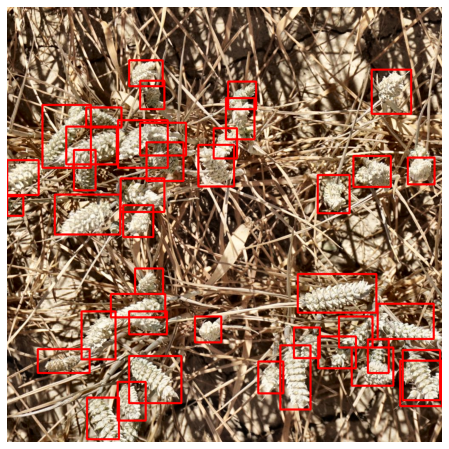

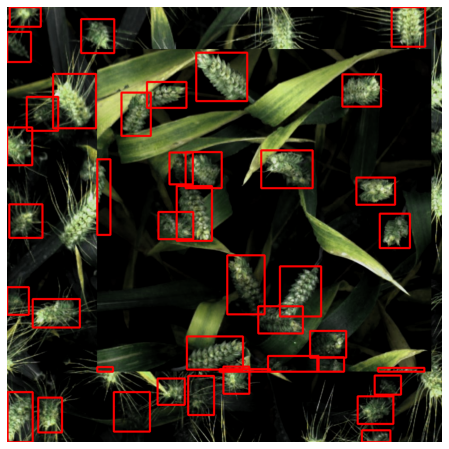

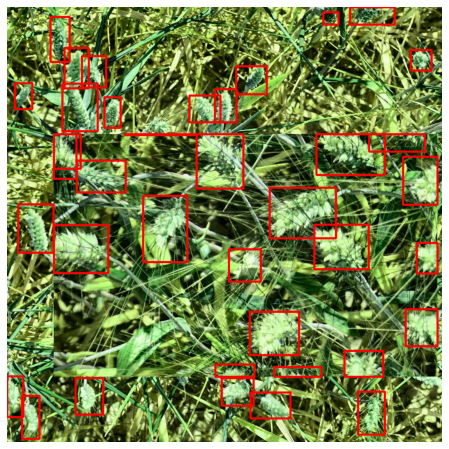

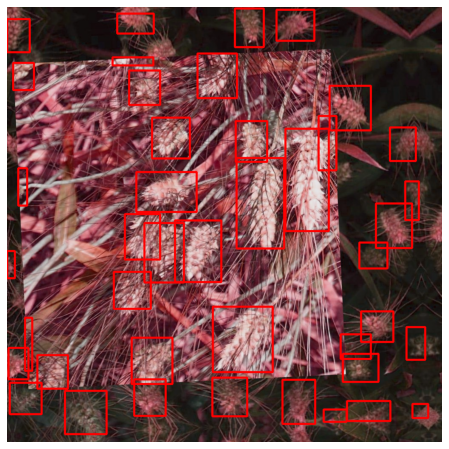

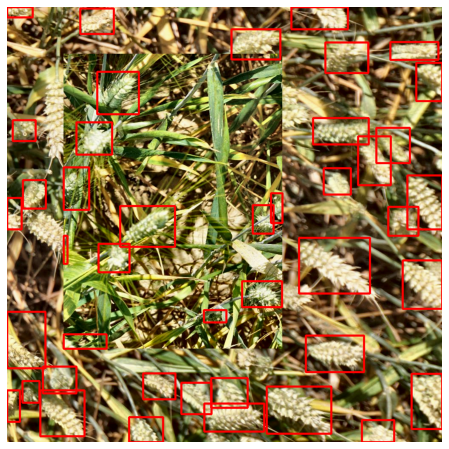

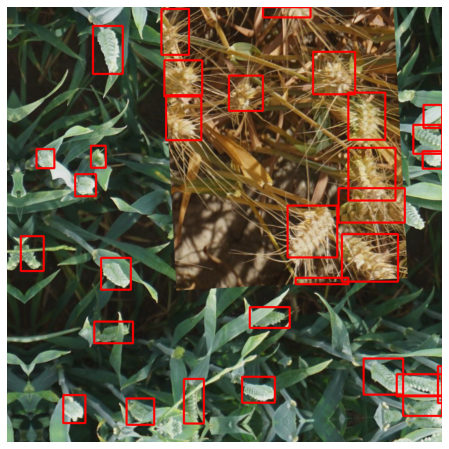

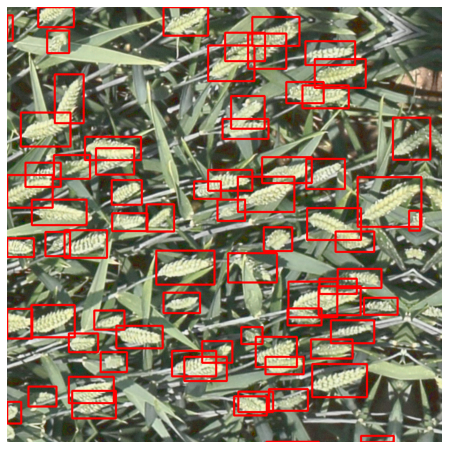

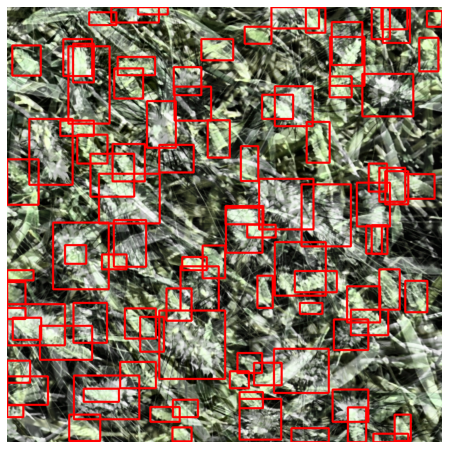

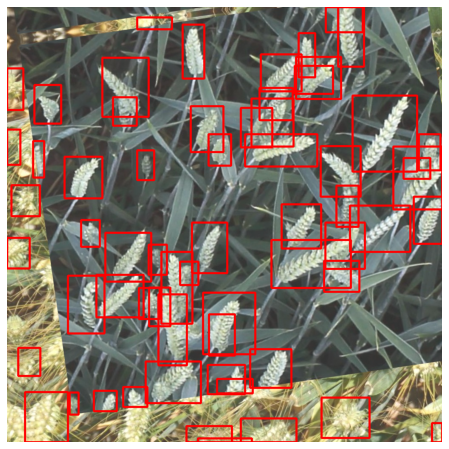

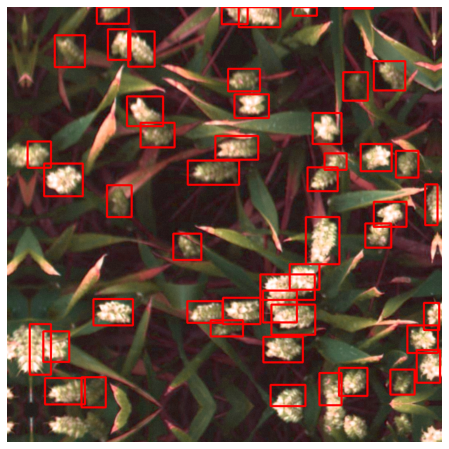

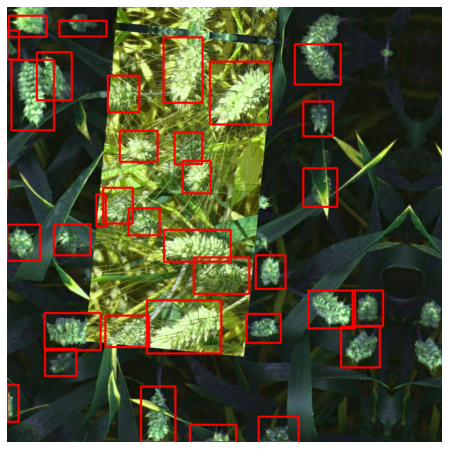

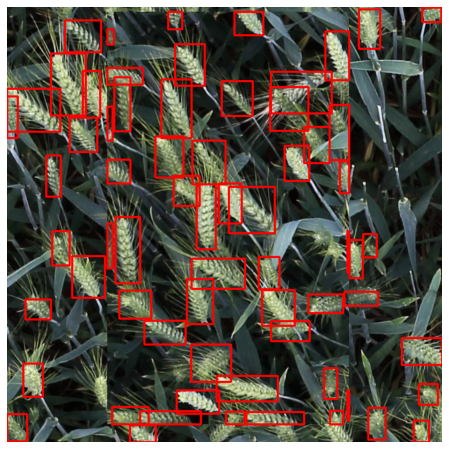

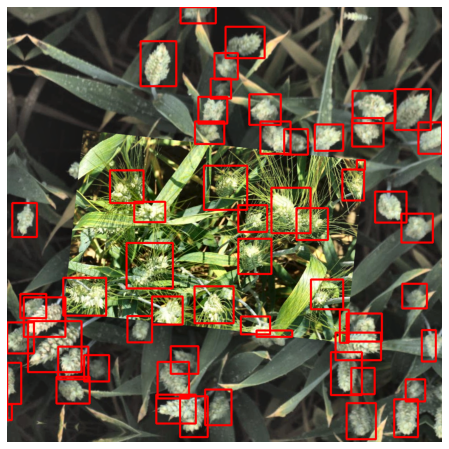

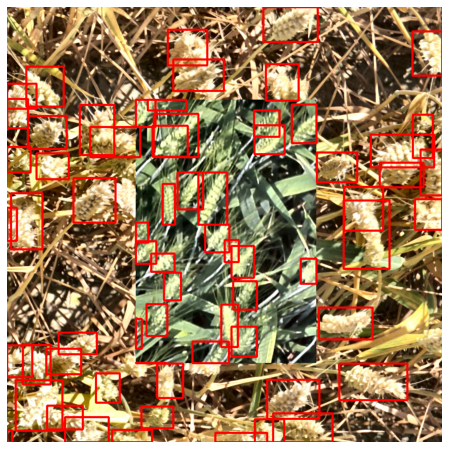

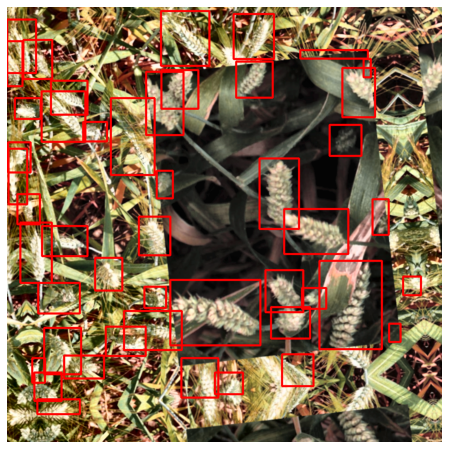

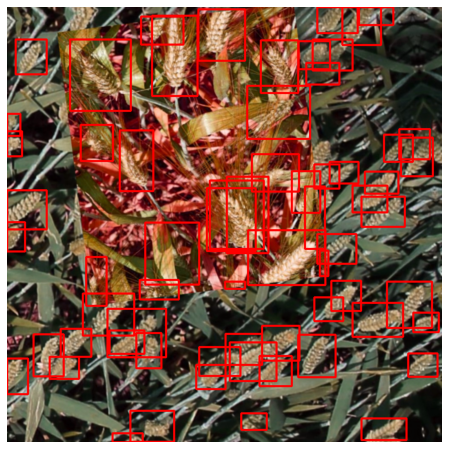

In [ ]:
%%time
def disp_augs(name):
    loader = DataLoader(
        get_training_datasets()[name], batch_size=16, shuffle=True, 
        num_workers=4, collate_fn=collate_fn
    )
    device = 'cuda'
    with torch.no_grad():
        for images, targets in loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            for image, target in zip(images, targets):
                boxes = target['boxes'].detach().cpu().numpy().astype(np.int32)
                sample = image.permute(1,2,0).detach().cpu().numpy()
                sample = (sample  * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
                simple_plot(sample, boxes)
                #print(image_id+'.jpg')
            return

disp_augs('train')


In [ ]:


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area

    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        #print(gts[gt_idx][0])
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision


In [ ]:
iou_thresholds = numba.typed.List()
for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)


## Model

In [ ]:
def timm_resnet_fpn_backbone(backbone_name, pretrained=True, trainable_layers=3):
    backbone = timm.create_model(backbone_name, pretrained=pretrained)

    # select layers that wont be frozen
    assert trainable_layers <= 5 and trainable_layers >= 0
    layers_to_train = ['layer4', 'layer3', 'layer2', 'layer1', 'conv1'][:trainable_layers]
    # freeze layers only if pretrained backbone is used
    for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)
            print(f'frozen {name}')

    return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}

    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [
        in_channels_stage2,
        in_channels_stage2 * 2,
        in_channels_stage2 * 4,
        in_channels_stage2 * 8,
    ]
    out_channels = 256
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)

def get_model(backbone_name='resnet50', detector_name='fasterrcnn', trainable_layers=3, model_ckpt=None):
    '''Constructs a fasterrcnn or maskrcnn detector with the given backbone'''
    num_classes = 2  # 1 class (wheat) + background
    if model_ckpt:
        #backbone = resnet_fpn_backbone('resnet101', True)
        backbone = timm_resnet_fpn_backbone(backbone_name, False, trainable_layers)
    else:
        backbone = timm_resnet_fpn_backbone(backbone_name, True, trainable_layers)
    if detector_name == 'fasterrcnn':
        #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        model = FasterRCNN(backbone, num_classes)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    elif detector_name == 'maskrcnn':
        model = MaskRCNN(backbone, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask, hidden_layer, num_classes
        )
    else:
        raise Exception(f"{detector_name} is not supported")
    if model_ckpt is not None:
        model.load_state_dict(torch.load(model_ckpt)['model_state_dict'])
        print('loaded ckpt')
    return model

def unfreeze_all_layers(model):
    layers_to_train = ['layer4', 'layer3', 'layer2', 'layer1', 'conv1'][:3]
    for name, parameter in model.backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(True)
    print(f'unfrozen all layers')
    return model

#model = get_model('gluon_seresnext101_32x4d')
#model.train()

## Train Scripts

In [ ]:
def train_one_epoch(model, loader, optimizer, scaler, device, scheduler=None, log=False):
    
    model.train()
    running_loss = 0.0   
    optimizer.zero_grad()
    for i, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        try:
            loss_dict = model(images, targets)
        except:
            tqdm.write('error detected...')
            continue
        losses = sum(loss / FLAGS['accumulation_steps'] for loss in loss_dict.values())
        loss_value = losses.item()
        running_loss+=float(loss_value)
        if scaler:
            scaler.scale(losses).backward()
        else:
            losses.backward()
            
        if (i+1) % FLAGS['accumulation_steps'] == 0:
            if scaler:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            if scheduler:
                scheduler.step()
            
        if log:
            for key in loss_dict:
                neptune.log_metric(
                    f'{key}/train', 
                    float(loss_dict[key].item()) / FLAGS['accumulation_steps'])

    return running_loss/len(loader)

def val_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    validation_image_precisions = []
    with torch.no_grad():
        for images, targets in tqdm(loader, total=len(loader)):
            images = list(image.to(device) for image in images)
            gt_boxes = np.array([target['boxes'].numpy() for target in targets])
            gt_labels = np.array([target['labels'].numpy() for target in targets])
            try:
                outputs = model(images)
            except:
                continue
            for i in range(len(images)): 
                pred_boxes = outputs[i].get('boxes').detach().cpu().numpy().astype(np.int32)
                scores = outputs[i].get('scores').detach().cpu().numpy()
                indexes = np.where(scores > 0.55)[0]
                target_boxes = gt_boxes[i].astype(np.int32)
                try:
                    image_precision = calculate_image_precision(
                        target_boxes, pred_boxes[indexes],
                        thresholds=iou_thresholds,
                        form='pascal_voc'
                    )
                except:
                    print('error in score calculation: ')
                    print('target_boxes', target_boxes)
                    print('pred_boxes', pred_boxes[indexes])
                    continue
                validation_image_precisions.append(image_precision)
             
    return np.array(validation_image_precisions).mean()

def save_upload(model, optimizer, epoch, scheduler, val_metric, exp_name, fold=None):
    if fold is not None:
        NAME = exp_name+f'_fold_{fold}_{str(epoch+1)}_map_'+ str(round(val_metric, 4)) +'.ckpt'   
    NAME = exp_name+f'_{str(epoch+1)}_map_'+ str(round(val_metric, 4)) +'.ckpt'
    MODEL_PATH = NAME
    torch.save({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
    }, MODEL_PATH)
    print(f"Saved ckpt for epoch {epoch+1}")
    upload_blob(MODEL_PATH, NAME)
    print(f"Uploaded ckpt for epoch {epoch+1}")


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
FLAGS = {}
FLAGS['num_workers'] = 4
FLAGS['batch_size'] = 2
FLAGS['accumulation_steps'] = 4
FLAGS['learning_rate'] = 1e-4
FLAGS['num_epochs'] = 60
FLAGS['weight_decay'] = 5e-3
FLAGS['exp_name'] = 'gluon_resnext101_32x4d_fasterrcnn'
FLAGS['fold'] = '0, 1, 2, 3'
FLAGS['trainable_layers'] = 5
FLAGS['unfreeze_epoch'] = 20
exp_description = '''
gluon_resnext101_32x4d_fasterrcnn,
Ranger, ReduceLROnPlateau
imsize 1024
'''

def train_job(model_name, detector_name, model_ckpt=None, log=True):
    exp_name = FLAGS['exp_name']
    if log:
        neptune.set_project('utsav/wheat-det')
        neptune.init('utsav/wheat-det', api_token=NEPTUNE_API_TOKEN)
        neptune.create_experiment(
            FLAGS['exp_name'], exp_description, params=FLAGS,
            upload_source_files='*.txt'
        )
    best_score = 0.0
    start_epoch = 0

    #sampler
    #labels_vcount = train_df['folds'].value_counts()
    #class_counts = [label_count.astype(np.float32) for label_count in labels_vcount)]
    #num_samples = sum(class_counts)
    #class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    #weights = [class_weights[train_df['folds'].values[i]] for i in range(int(num_samples))]
    #sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

    datasets = get_training_datasets()
    train_loader = DataLoader(
        datasets['train'], batch_size=FLAGS['batch_size'], 
        num_workers=FLAGS['num_workers'], shuffle=True, #shuffle=True,  # sampler=sampler
        collate_fn=collate_fn, pin_memory=True
    )
    val_loader = DataLoader(
        datasets['valid'], batch_size=FLAGS['batch_size']*4, shuffle=False, 
        num_workers=FLAGS['num_workers'], collate_fn=collate_fn, pin_memory=True
    )

    if model_ckpt is None:
        model = get_model(model_name, detector_name, FLAGS['trainable_layers'])
    else:
        model = get_model(model_name, detector_name, FLAGS['trainable_layers'], model_ckpt)
        start_epoch = torch.load(model_ckpt)['epoch']
    model.to(device)

    optimizer = Ranger(
        model.parameters(),
        lr=FLAGS['learning_rate'], 
        alpha=0.5, k=6, N_sma_threshhold=5,
        weight_decay=FLAGS['weight_decay']
    )

    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', factor=0.75, verbose=True, patience=4
    )

    es = 0
    scaler = GradScaler()
    for epoch in range(start_epoch, FLAGS['num_epochs']):

        print('-'*27 + f'Epoch #{epoch+1} started' + '-'*27)
        
        train_loss = train_one_epoch(
            model, train_loader, optimizer,
            scaler, device, scheduler=None, log=log
        )
        print(f'Average loss for epoch #{epoch+1} : {train_loss}')

        val_metric = val_one_epoch(model, val_loader)
        scheduler.step(-val_metric)
        print(f'metric/val : {val_metric}')
    
        if log:
            neptune.log_metric('metric/val', val_metric)
        
        #if epoch+1 == FLAGS['unfreeze_epoch']:
        #    model = unfreeze_all_layers(model)

        if (val_metric > best_score) or (best_score-val_metric<0.01):
            es = 0
            if (val_metric > best_score):
                best_score = val_metric
            if epoch>4:
                save_upload(
                    model, optimizer, epoch, 
                    scheduler, val_metric, 
                    exp_name=FLAGS['exp_name']
                )
        #else:
        #    es+=1
        #    print('early stop counter: ', es)
        #    if es > 9 and epoch>19:
        #        print('early stopping...')
        #        break

        print('-'*28 + f'Epoch #{epoch+1} ended' + '-'*28)

    neptune.stop()


In [ ]:
#class_counts = [len(train_df[train_df['source'] == k]['image_id'].unique()) for k in mapping if len(train_df[train_df['source'] == k]['image_id'].unique()) != 0]
#num_samples = sum(class_counts)
#class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
#unique_ims = [train_df[train_df['source'] == k]['image_id'].unique() for k in mapping if len(train_df[train_df['source'] == k]['image_id'].unique()) != 0]
##weights = [class_weights[train_df['folds'].values[i]] for i in range(int(num_samples))]
##sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

## Train

In [ ]:
#try:
train_job('gluon_resnext101_32x4d', 'fasterrcnn', model_ckpt='./gluon_resnext101_32x4d_fasterrcnn_7_map_0.4731.ckpt', log=True)
#except KeyboardInterrupt:
#    neptune.stop()
#except:
#neptune.stop()

https://ui.neptune.ai/utsav/wheat-det/e/WHEAT-95
frozen bn1.weight
frozen bn1.bias
frozen fc.weight
frozen fc.bias
loaded ckpt
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
---------------------------Epoch #7 started---------------------------


  0%|          | 0/1117 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #7 : 0.19234064946429688


  1%|          | 1/143 [00:04<11:22,  4.80s/it]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
100%|██████████| 143/143 [01:29<00:00,  1.60it/s]


metric/val : 0.5057401366775148
Saved ckpt for epoch 7
File gluon_resnext101_32x4d_fasterrcnn_7_map_0.5057.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_7_map_0.5057.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_7_map_0.5057.ckpt
Uploaded ckpt for epoch 7
----------------------------Epoch #7 ended----------------------------
---------------------------Epoch #8 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #8 : 0.18997126241400505


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5325318036139837
Saved ckpt for epoch 8
File gluon_resnext101_32x4d_fasterrcnn_8_map_0.5325.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_8_map_0.5325.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_8_map_0.5325.ckpt
Uploaded ckpt for epoch 8
----------------------------Epoch #8 ended----------------------------
---------------------------Epoch #9 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #9 : 0.18645888645678838


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.523471097025759
Saved ckpt for epoch 9
File gluon_resnext101_32x4d_fasterrcnn_9_map_0.5235.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_9_map_0.5235.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_9_map_0.5235.ckpt
Uploaded ckpt for epoch 9
----------------------------Epoch #9 ended----------------------------
---------------------------Epoch #10 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #10 : 0.1848656091715677


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5268352512830353
Saved ckpt for epoch 10
File gluon_resnext101_32x4d_fasterrcnn_10_map_0.5268.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_10_map_0.5268.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_10_map_0.5268.ckpt
Uploaded ckpt for epoch 10
----------------------------Epoch #10 ended----------------------------
---------------------------Epoch #11 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #11 : 0.1844918581798019


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5441606859322464
Saved ckpt for epoch 11
File gluon_resnext101_32x4d_fasterrcnn_11_map_0.5442.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_11_map_0.5442.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_11_map_0.5442.ckpt
Uploaded ckpt for epoch 11
----------------------------Epoch #11 ended----------------------------
---------------------------Epoch #12 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #12 : 0.18204020442659555


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5383046323223877
Saved ckpt for epoch 12
File gluon_resnext101_32x4d_fasterrcnn_12_map_0.5383.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_12_map_0.5383.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_12_map_0.5383.ckpt
Uploaded ckpt for epoch 12
----------------------------Epoch #12 ended----------------------------
---------------------------Epoch #13 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #13 : 0.18011064426564913


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5211350788587126
----------------------------Epoch #13 ended----------------------------
---------------------------Epoch #14 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #14 : 0.17881593745845498


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5346342191179067
Saved ckpt for epoch 14
File gluon_resnext101_32x4d_fasterrcnn_14_map_0.5346.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_14_map_0.5346.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_14_map_0.5346.ckpt
Uploaded ckpt for epoch 14
----------------------------Epoch #14 ended----------------------------
---------------------------Epoch #15 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #15 : 0.17559594518922755


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5211756524821793
----------------------------Epoch #15 ended----------------------------
---------------------------Epoch #16 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #16 : 0.17500422946314995


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

Epoch    10: reducing learning rate of group 0 to 7.5000e-05.
metric/val : 0.49614220447343926
----------------------------Epoch #16 ended----------------------------
---------------------------Epoch #17 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #17 : 0.17286594200715916


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.4992507664168405
----------------------------Epoch #17 ended----------------------------
---------------------------Epoch #18 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #18 : 0.17012444170543736


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5010136308515665
----------------------------Epoch #18 ended----------------------------
---------------------------Epoch #19 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #19 : 0.16821700960210956


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5169816699963576
----------------------------Epoch #19 ended----------------------------
---------------------------Epoch #20 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #20 : 0.1692314748931593


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5056327521598923
----------------------------Epoch #20 ended----------------------------
---------------------------Epoch #21 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #21 : 0.16544689147357122


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5568658222270919
Saved ckpt for epoch 21
File gluon_resnext101_32x4d_fasterrcnn_21_map_0.5569.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_21_map_0.5569.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_21_map_0.5569.ckpt
Uploaded ckpt for epoch 21
----------------------------Epoch #21 ended----------------------------
---------------------------Epoch #22 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #22 : 0.16665215442755868


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5053505135348704
----------------------------Epoch #22 ended----------------------------
---------------------------Epoch #23 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #23 : 0.16378200945970514


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5234125143882484
----------------------------Epoch #23 ended----------------------------
---------------------------Epoch #24 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #24 : 0.16338184852763382


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5381262203767953
----------------------------Epoch #24 ended----------------------------
---------------------------Epoch #25 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #25 : 0.16157401880064284


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5496562108858708
Saved ckpt for epoch 25
File gluon_resnext101_32x4d_fasterrcnn_25_map_0.5497.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_25_map_0.5497.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_25_map_0.5497.ckpt
Uploaded ckpt for epoch 25
----------------------------Epoch #25 ended----------------------------
---------------------------Epoch #26 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #26 : 0.15992622198862164


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

Epoch    20: reducing learning rate of group 0 to 5.6250e-05.
metric/val : 0.5231410401156457
----------------------------Epoch #26 ended----------------------------
---------------------------Epoch #27 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #27 : 0.15945474044382305


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5553199826562178
Saved ckpt for epoch 27
File gluon_resnext101_32x4d_fasterrcnn_27_map_0.5553.ckpt uploaded to global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_27_map_0.5553.ckpt.
uploaded blob name:  global-wheat-detection/18_June/gluon_resnext101_32x4d_fasterrcnn_27_map_0.5553.ckpt
Uploaded ckpt for epoch 27
----------------------------Epoch #27 ended----------------------------
---------------------------Epoch #28 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #28 : 0.1570817146286862


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5281286408587893
----------------------------Epoch #28 ended----------------------------
---------------------------Epoch #29 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #29 : 0.1569194815045718


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5296971091216448
----------------------------Epoch #29 ended----------------------------
---------------------------Epoch #30 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #30 : 0.1557162820545818


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.522575349447694
----------------------------Epoch #30 ended----------------------------
---------------------------Epoch #31 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #31 : 0.15481932541303797


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


metric/val : 0.5753029222723055
Saved ckpt for epoch 31
File gluon_resnext101_32x4d_fasterrcnn_31_map_0.5753.ckpt uploaded to global-wheat-detection/19_June/gluon_resnext101_32x4d_fasterrcnn_31_map_0.5753.ckpt.
uploaded blob name:  global-wheat-detection/19_June/gluon_resnext101_32x4d_fasterrcnn_31_map_0.5753.ckpt
Uploaded ckpt for epoch 31
----------------------------Epoch #31 ended----------------------------
---------------------------Epoch #32 started---------------------------


  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #32 : 0.15425389828352173


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.533645887652425
----------------------------Epoch #32 ended----------------------------
---------------------------Epoch #33 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #33 : 0.15306688106769734


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5502955361397875
----------------------------Epoch #33 ended----------------------------
---------------------------Epoch #34 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #34 : 0.15198756030684832


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.5448867181097378
----------------------------Epoch #34 ended----------------------------
---------------------------Epoch #35 started---------------------------



  0%|          | 0/143 [00:00<?, ?it/s]

Average loss for epoch #35 : 0.15285877232425643


100%|██████████| 143/143 [01:26<00:00,  1.65it/s]

metric/val : 0.510579941182934
----------------------------Epoch #35 ended----------------------------
---------------------------Epoch #36 started---------------------------



 92%|█████████▏| 1033/1117 [12:19<01:00,  1.40it/s]

## Predict

In [ ]:
def write_output(sample, target_boxes, boxes=None, filename=None):
    sample = sample * 255.
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 255), 3)
    for box in target_boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (255, 0, 0), 3)
    if not os.path.exists('output'):
        os.makedirs('output')
    if filename is not None:
        cv2.imwrite('./output/'+filename+'.jpg', sample)
    

In [ ]:
!gsutil cp gs://utsav-data/global-wheat-detection/19_June/gluon_resnext101_32x4d_fasterrcnn_31_map_0.5753.ckpt model.ckpt

Copying gs://utsav-data/global-wheat-detection/19_June/gluon_resnext101_32x4d_fasterrcnn_31_map_0.5753.ckpt...
\ [1 files][229.4 MiB/229.4 MiB]                                                
Operation completed over 1 objects/229.4 MiB.                                    


In [ ]:
model = get_model('gluon_resnext101_32x4d', model_ckpt='model.ckpt')
model.eval().cuda()
print('Model loaded')

In [ ]:
def predict(detection_threshold=0.4, write_output=False):
    test_loader = DataLoader(
        get_training_datasets()['valid'], batch_size=8*4, shuffle=False, 
        num_workers=4, collate_fn=collate_fn
    )
    iou_thresholds = numba.typed.List()
    for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
        iou_thresholds.append(x)
    validation_image_precisions2 = []
    with torch.no_grad():
        for images, targets in tqdm(test_loader, total=len(test_loader)):
            images = list(image.to(device) for image in images)
            gt_boxes = np.array([target['boxes'].numpy() for target in targets])
            gt_labels = np.array([target['labels'].numpy() for target in targets])
            try:
                outputs = model(images)
            except:
                continue
            for i in range(len(images)): 
                pred_boxes = outputs[i].get('boxes').detach().cpu().numpy().astype(np.int32)
                scores = outputs[i].get('scores').detach().cpu().numpy()
                indexes = np.where(scores > detection_threshold)[0]
                target_boxes = gt_boxes[i].astype(np.int32)
                image_precision = calculate_image_precision(
                    target_boxes, pred_boxes[indexes],
                    thresholds=iou_thresholds,
                    form='pascal_voc'
                )
                validation_image_precisions2.append(image_precision)

                if write_output==True:
                    image = images[i].permute(1,2,0).cpu().numpy()
                    image = np.ascontiguousarray(image)
                    image = (image  * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
                    
                    #write_output(image, target_boxes, boxes=pred_boxes[indexes], filename=image_ids[i])
                    #double_plot(image, target_boxes, pred_boxes[indexes])
                    #plot(image, target_boxes, boxes)

    print(f"Validation IOU: {np.mean(validation_image_precisions2):.5f}, det threshold: {detection_threshold}")
    return np.mean(validation_image_precisions2)


In [ ]:
best_map_score = 0.0
thresh = 0.0
score_list = []
for i in list(range(69, 86, 1)):
    score = predict(i/100.0)
    score_list.append({'thresh':i/100.0, 'score':score})
    if score > best_map_score:
        best_map_score = score
        thresh = i/100.0
print(f'best score: {best_map_score} at theshold {thresh}')

  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  3%|▎         | 1/36 [00:08<05:08,  8.83s/it]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor w

Validation IOU: 0.58949, det threshold: 0.69


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.58996, det threshold: 0.7


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59043, det threshold: 0.71


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59104, det threshold: 0.72


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59153, det threshold: 0.73


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59236, det threshold: 0.74


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59286, det threshold: 0.75


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59327, det threshold: 0.76


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59408, det threshold: 0.77


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59436, det threshold: 0.78


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59409, det threshold: 0.79


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59488, det threshold: 0.8


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59473, det threshold: 0.81


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59508, det threshold: 0.82


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59513, det threshold: 0.83


  0%|          | 0/36 [00:00<?, ?it/s]

Validation IOU: 0.59436, det threshold: 0.84


100%|██████████| 36/36 [01:29<00:00,  2.47s/it]

Validation IOU: 0.59395, det threshold: 0.85
best score: 0.5951313796146186 at theshold 0.83
